In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape, test.shape)
df_data = pd.concat([train, test], axis=0).reset_index(drop=True)

print(df_data.shape)
df_data.head(2)

(681204, 6) (172874, 6)
(854078, 6)


,peptide,nterm,cterm,miss1,miss2,label
0,ERISVAAASK,RIYELRNKERISVAA,ISVAAASKLLANMVY,YELRNKERISVAAAS,ZZZZZZZZZZZZZZZ,True
1,MLAEDELRDAVLLVFANKQDLPNAMNAAEITDK,EAREELMRMLAEDEL,NAAEITDKLGLHSLR,MLAEDELRDAVLLVF,VLLVFANKQDLPNAM,True


In [3]:
df_data.iloc[-5:]

,peptide,nterm,cterm,miss1,miss2,label
854073,KPGHVAEVYLVHLHASVYALFHRLYGMYPCNFVSFLR,RLSSWCLKKPGHVAE,CNFVSFLRSHYSMKE,LSSWCLKKPGHVAEV,SVYALFHRLYGMYPC,False
854074,LDQPKLDEVTRR,LKIAQRLRLDQPKLD,KLDEVTRRIKQGSPN,RLRLDQPKLDEVTRR,PKLDEVTRRIKQGSP,False
854075,YQSSPAK,QRELLRRRYQSSPAK,RYQSSPAKPDSSFYK,ZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZ,False
854076,DPDGAHRASSLANLGELCQR,HTFLRGVRDPDGAHR,NLGELCQRLDFLLGS,RDPDGAHRASSLANL,ZZZZZZZZZZZZZZZ,False
854077,EIFVAIK,HLKLPGKREIFVAIK,REIFVAIKTLKSGYT,ZZZZZZZZZZZZZZZ,ZZZZZZZZZZZZZZZ,False


In [4]:
f = open('data/data.json')
data = json.load(f)
f.close()
# prot_name : prot_info
# prot_info : sequence, cleavage_cnt, miss_cleavage_cnt, peptides, peptide_tree, coverage, labelled_peptides
    # labelled_peptides : peptide
        # peptide : n, c, m1, m2

# check peptide multi label in detectability

* in raw file

In [5]:
dup_raw = dict()  # multi label key
dup_prot = dict()  # to check multi labelled peptide
for prot_name, prot_info in data.items():
    pep_dic = prot_info['labelled_peptides']
    for pset, lab in pep_dic.items():
        p, n, c, m1, m2 = pset.split()
        k = (p, n, c, m1, m2)
        if k not in dup_prot:
            dup_prot[k] = set()
        if k not in dup_raw:
            dup_raw[k] = set()
        dup_prot[k].add((lab, prot_name))
        dup_raw[k].add(lab)
dup_prot = dict(filter(lambda x: len(x[1])>=2, dup_prot.items()))
dup_raw = dict(filter(lambda x: len(x[1])>=2, dup_raw.items()))

In [6]:
print(len(dup_raw))
for idx, k in enumerate(dup_raw):
    print('\n', f'{idx+1}st duplicated peptide : ', k)
    for lab, prot_name in dup_prot[k]:
        print(prot_name, data[prot_name]['sequence'], lab)

8

 1st duplicated peptide :  ('PAPAQKPAQLKEEK', 'GRKPGEARPAPAQKP', 'PAQLKEEKMEERDLL', 'ARPAPAQKPAQLKEE', 'AQKPAQLKEEKMEER')
sp|P21127|CD11B_HUMAN MGDEKDSWKVKTLDEILQEKKRRKEQEEKAEIKRLKNSDDRDSKRDSLEEGELRDHRMEITIRNSPYRREDSMEDRGEEDDSLAIKPPQQMSRKEKAHHRKDEKRKEKRRHRSHSAEGGKHARVKEKEREHERRKRHREEQDKARREWERQKRREMAREHSRRERDRLEQLERKRERERKMREQQKEQREQKERERRAEERRKEREARREVSAHHRTMREDYSDKVKASHWSRSPPRPPRERFELGDGRKPGEARPAPAQKPAQLKEEKMEERDLLSDLQDISDSERKTSSAESSSAESGSGSEEEEEEEEEEEEEGSTSEESEEEEEEEEEEEEETGSNSEEASEQSAEEVSEEEMSEDEERENENHLLVVPESRFDRDSGESEEAEEEVGEGTPQSSALTEGDYVPDSPALSPIELKQELPKYLPALQGCRSVEEFQCLNRIEEGTYGVVYRAKDKKTDEIVALKRLKMEKEKEGFPITSLREINTILKAQHPNIVTVREIVVGSNMDKIYIVMNYVEHDLKSLMETMKQPFLPGEVKTLMIQLLRGVKHLHDNWILHRDLKTSNLLLSHAGILKVGDFGLAREYGSPLKAYTPVVVTLWYRAPELLLGAKEYSTAVDMWSVGCIFGELLTQKPLFPGKSEIDQINKVFKDLGTPSEKIWPGYSELPAVKKMTFSEHPYNNLRKRFGALLSDQGFDLMNKFLTYFPGRRISAEDGLKHEYFRETPLPIDPSMFPTWPAKSEQQRVKRGTSPRPPEGGLGYSQLGDDDLKETGFHLTTTNQGASAAGPGFSLKF False
sp|Q9UQ88|CD11A_HUMAN MGDEKDSWKVKTLDEILQEKKRRKEQEEK

* in csv file (after preprocessing)

In [7]:
tmp = pd.concat([train, test], axis=0)
peptide = dict()
for pep, n, c, m1, m2, lab in tmp.values:
    pset = (pep, n, c, m1, m2)
    if pset not in peptide:
        peptide[pset] = set()
    peptide[pset].add(lab)
print(list(filter(lambda x: len(x[1])>=2, peptide.items())))  # no duplicates

[]


# Figure1

In [8]:
# find highest sequence coverage protein
cov = -1
for prot_name, prot_info in data.items():
    cur_cov = prot_info['coverage']
    if cur_cov > cov:
        viz_prot_name = prot_name
        cov = cur_cov

In [9]:
data['sp|Q06265|EXOS9_HUMAN']['coverage']

0.765375854214123

In [10]:
viz_prot_name = 'sp|Q06265|EXOS9_HUMAN'

In [11]:
seq, peptides = data[viz_prot_name]['sequence'], data[viz_prot_name]['peptides']

x = range(len(seq))
Lys = [1 if aa == 'K' else 0 for idx, aa in enumerate(seq)]
Arg = [1 if aa == 'R' else 0 for idx, aa in enumerate(seq)]
fully_tryptic = lambda p: p[-1] in {'K', 'R'} and seq[seq.find(p) - 1] in {'K', 'R'}
peptides_idx = {range(seq.find(p), seq.find(p) + len(p)):cnt for p, cnt in peptides.items() if fully_tryptic(p)}

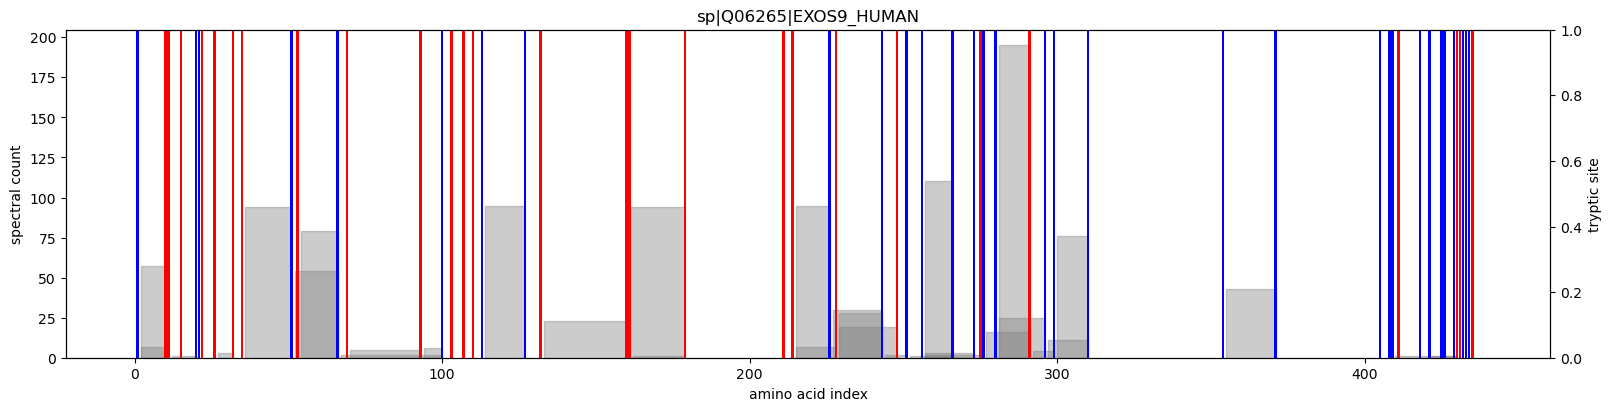

In [12]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,4))
ax2 = ax.twinx()
for k, v in peptides_idx.items():
    ax.fill_between(k, 0, [v]*len(k), color='gray', alpha=0.4)
ax2.bar(x, Lys, color='blue')  # Lysine
ax2.bar(x, Arg, color='red')  # Arginine

plt.title(viz_prot_name)
ax.set_xlabel('amino acid index')
ax.set_ylabel('spectral count')
ax2.set_ylabel('tryptic site')
ax.set_ylim(0,)
ax2.set_ylim(0, 1)
plt.show()

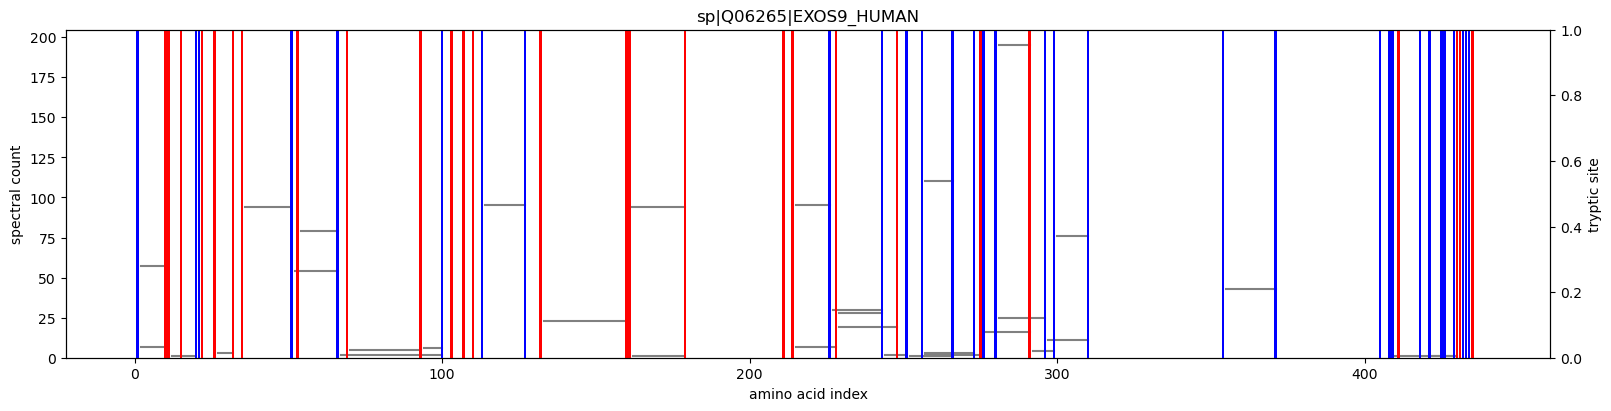

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,4))
ax2 = ax.twinx()
# for k, v in peptides_idx.items():
#     ax.fill_between(k, 0, [v]*len(k), color='gray', alpha=0.4)
for aa_idx_range, spectral_cnt in peptides_idx.items():
    sc = [spectral_cnt] * len(aa_idx_range)
    ax.plot(aa_idx_range, sc, color='gray')
ax2.bar(x, Lys, color='blue')  # Lysine
ax2.bar(x, Arg, color='red')  # Arginine

plt.title(viz_prot_name)
ax.set_xlabel('amino acid index')
ax.set_ylabel('spectral count')
ax2.set_ylabel('tryptic site')
ax.set_ylim(0,)
ax2.set_ylim(0, 1)
plt.show()

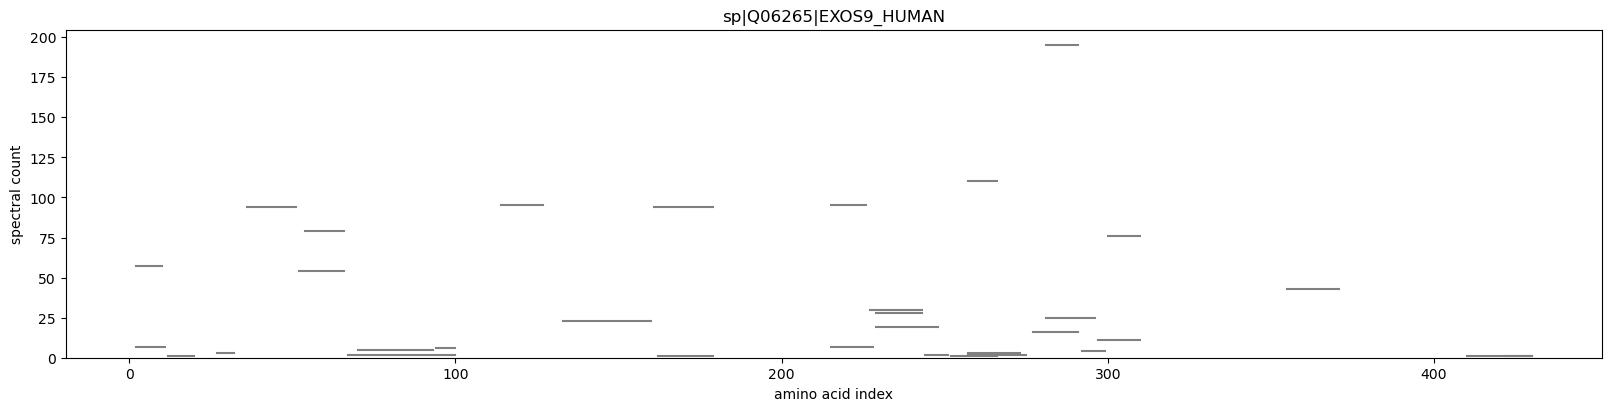

In [14]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,4))
# ax2 = ax.twinx()
# for k, v in peptides_idx.items():
#     ax.fill_between(k, 0, [v]*len(k), color='gray', alpha=0.4)
for aa_idx_range, spectral_cnt in peptides_idx.items():
    sc = [spectral_cnt] * len(aa_idx_range)
    ax.plot(aa_idx_range, sc, color='gray')
# ax2.bar(x, Lys, color='blue')  # Lysine
# ax2.bar(x, Arg, color='red')  # Arginine

plt.title(viz_prot_name)
ax.set_xlabel('amino acid index')
ax.set_ylabel('spectral count')
# ax2.set_ylabel('tryptic site')
ax.set_ylim(0,)
ax2.set_ylim(0, 1)
plt.show()

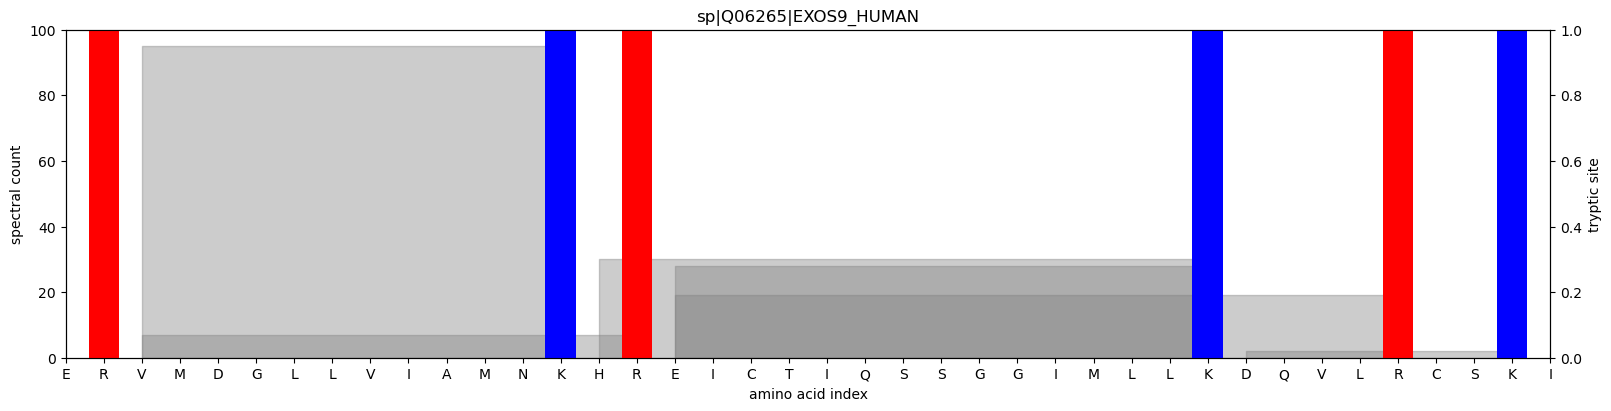

In [15]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,4))
ax2 = ax.twinx()
for k, v in peptides_idx.items():
    ax.fill_between(k, 0, [v]*len(k), color='gray', alpha=0.4)
ax2.bar(x, Lys, color='blue')  # Lysine
ax2.bar(x, Arg, color='red')  # Arginine

plt.title(viz_prot_name)
ax.set_xlabel('amino acid index')
ax.set_ylabel('spectral count')
ax2.set_ylabel('tryptic site')
ax.set_ylim(0, 100)
ax.set_xlim(213, 252)
ax2.set_ylim(0, 1)
ax.set_xticks(range(213, 253))
ax.set_xticklabels(list(seq[213: 253]))
plt.show()

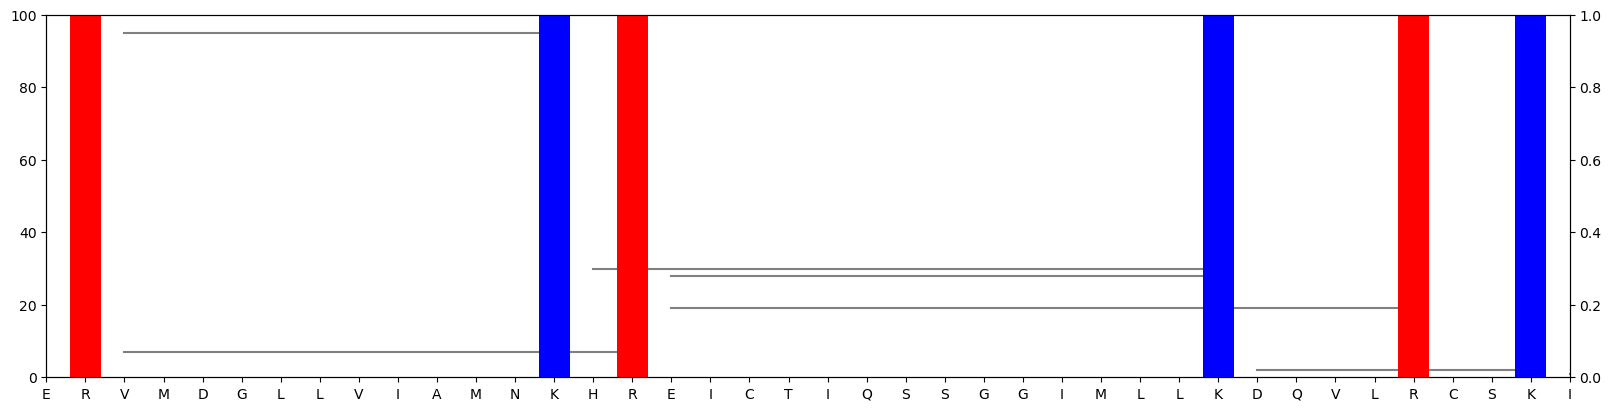

In [16]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,4))
ax2 = ax.twinx()
for aa_idx_range, spectral_cnt in peptides_idx.items():
    sc = [spectral_cnt] * len(aa_idx_range)
    ax.plot(aa_idx_range, sc, color='gray')
ax2.bar(x, Lys, color='blue')  # Lysine
ax2.bar(x, Arg, color='red')  # Arginine

# plt.title(viz_prot_name)
# ax.set_xlabel('amino acid index')
# ax.set_ylabel('spectral count')
# ax2.set_ylabel('tryptic site')
ax.set_ylim(0, 100)
ax.set_xlim(213, 252)
ax2.set_ylim(0, 1)
ax.set_xticks(range(213, 253))
ax.set_xticklabels(list(seq[213: 253]))
plt.show()

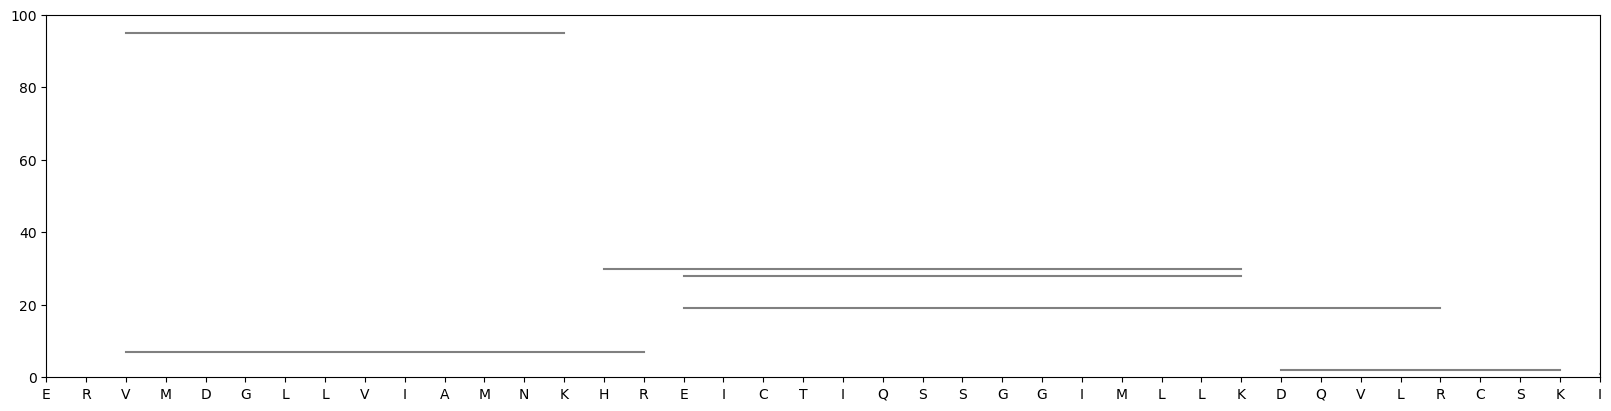

In [17]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,4))
# ax2 = ax.twinx()
for aa_idx_range, spectral_cnt in peptides_idx.items():
    sc = [spectral_cnt] * len(aa_idx_range)
    ax.plot(aa_idx_range, sc, color='gray')
# ax2.bar(x, Lys, color='blue')  # Lysine
# ax2.bar(x, Arg, color='red')  # Arginine

# plt.title(viz_prot_name)
# ax.set_xlabel('amino acid index')
# ax.set_ylabel('spectral count')
# ax2.set_ylabel('tryptic site')
ax.set_ylim(0, 100)
ax.set_xlim(213, 252)
ax2.set_ylim(0, 1)
ax.set_xticks(range(213, 253))
ax.set_xticklabels(list(seq[213: 253]))
plt.show()

# massIVE-KB - HPP

In [18]:
hpp = pd.read_csv('2019Bioinformatics_DeepMSPeptide/Datasets/HPP_validation_peptides.txt', sep='\t')

In [19]:
hpp.Class.value_counts()

PE1             8000
Detected_MPs    8000
MPs             7910
Name: Class, dtype: int64

In [20]:
print('PE1: ', len(hpp.loc[hpp.Class=='PE1'].Peptide_seq.unique()),
     '\nDetected_MPs: ', len(hpp.loc[hpp.Class=='Detected_MPs'].Peptide_seq.unique()),
     '\nMPs: ', len(hpp.loc[hpp.Class=='MPs'].Peptide_seq.unique()))

PE1:  8000 
Detected_MPs:  8000 
MPs:  7910


In [21]:
hpp_pep_seq = hpp.Peptide_seq.unique()

massivekb = pd.concat([train, test], axis=0).reset_index(drop=True)
train_idx = massivekb.iloc[:len(train)].index
test_idx = massivekb.iloc[len(train):].index
df_drop = pd.DataFrame([[p, True] for p in hpp_pep_seq], columns=['peptide', 'drop_flag'])
massivekb_drop = massivekb.merge(df_drop, on='peptide', how='left').fillna(False)
massivekb = massivekb_drop.loc[massivekb_drop.drop_flag==False].drop(['drop_flag'], axis=1)
massivekb_idx = massivekb.index
train_idx = set(train_idx).intersection(set(massivekb_idx))
test_idx = set(test_idx).intersection(set(massivekb_idx))

train = massivekb.loc[train_idx].reset_index(drop=True)
test = massivekb.loc[test_idx].reset_index(drop=True)

In [22]:
# find max peptides length
print(
    len(max(train.peptide.unique(), key=lambda x: len(x))), 
    len(max(test.peptide.unique(), key=lambda x: len(x))),
    len(max(hpp.Peptide_seq.unique(), key=lambda x: len(x))),
)

40 40 81


In [23]:
# train.to_csv('data/train_diff_hpp.csv', index=False)
# test.to_csv('data/test_diff_hpp.csv', index=False)

# HPP - semi tryptic

In [24]:
from preprocessing import *
from ahocorapy.keywordtree import KeywordTree

path = '/home/bis/2021_SJH_detectability/Detectability/data/'
fasta_fn = 'uniprot/uniprot-proteome_UP000005640.fasta'

hpp_peptides = hpp.Peptide_seq.values
pep_cnt = {p: 2 for p in hpp_peptides}
pep_tree = KeywordTree()
for peptide in hpp_peptides:
    pep_tree.add(peptide)
pep_tree.finalize()

prot_seq = get_protein(path + fasta_fn)
uniprot_prot = set(prot_seq.keys())
prot_seq_peptide = dict()
for prot_name in uniprot_prot:
    prot_seq_peptide[prot_name] = {'sequence': prot_seq[prot_name],
                                  'peptide_tree': pep_tree,
                                  'peptides': pep_cnt}

In [25]:
prot_seq_peptide = get_peptide_from_protein(prot_seq_peptide, 7)

In [26]:
dupli = dict()
for prot_name, prot_info in prot_seq_peptide.items():
    for pep_set, label in prot_info['labelled_peptides'].items():
        p, n, c, m1, m2 = pep_set.split()
        pep_set = (p, n, c, m1, m2)
        if pep_set not in dupli:
            dupli[pep_set] = set()
        dupli[pep_set].add(label)
peptides = set()
for pep_set, labels in dupli.items():
    label = max(labels)
    p, n, c, m1, m2 = pep_set
    peptides.add((p, n, c, m1, m2, label))

df_hpp = pd.DataFrame(peptides,
                         columns = ['peptide', 'nterm', 'cterm', 'miss1', 'miss2', 'label'])

# remove duplicated peptide context
df_hpp.drop_duplicates(inplace=True, ignore_index=True)
df_hpp = df_hpp.loc[df_hpp.label==True].reset_index(drop=True).drop(['label'], axis=1)

# Labelling
df_hpp = df_hpp.merge(hpp.rename({'Peptide_seq': 'peptide'}, axis=1), on='peptide', how='inner')
pe = df_hpp.loc[df_hpp.Class=='PE1']
dmp = df_hpp.loc[df_hpp.Class=='Detected_MPs']
mp = df_hpp.loc[df_hpp.Class=='MPs']

In [27]:
df_hpp.Class.value_counts()

PE1             8555
Detected_MPs    8484
MPs             6234
Name: Class, dtype: int64

In [28]:
print('PE1: ', len(pe.peptide.unique()),
      '\nDetected_MPs: ', len(dmp.peptide.unique()),
      '\nMPs: ', len(mp.peptide.unique()),
     )

PE1:  7792 
Detected_MPs:  7756 
MPs:  6001


In [29]:
# df_hpp.to_csv('data/HPP.csv', index=False)

In [30]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=7)
whole = pd.concat([train, val, test], axis=0)
print(f'data cnt : train {train.shape[0]}, val {val.shape[0]}, test {test.shape[0]}',
     '\nided peptides cnt : ', len(whole.loc[whole.label==True][['peptide']].drop_duplicates()))

data cnt : train 536492, val 134124, test 170367 
ided peptides cnt :  408205
